In [1]:
import os
import sys
import time
import math
import argparse
from dataclasses import dataclass
from typing import List

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

# Bigram

In [2]:
class Bigram(nn.Module):
    """
    Bigram Language Model 'neural net', simply a lookup table of logits for the
    next character given a previous character.
    """

    def __init__(self, vocab_size):
        super().__init__()
        n = vocab_size
        self.logits = nn.Parameter(torch.zeros((n, n)))

    def get_block_size(self):
        return 1 # this model only needs one previous character to predict the next

    def forward(self, idx, targets=None):

         # 'forward pass', lol
        logits = self.logits[idx]
        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        # this is the loss from the video, but optimized for stability (logsumexp trick)
        loss_simple = None
        if targets is not None:
            loss_simple = -nn.LogSoftmax(dim=-1)(logits)[torch.arange(len(idx)), targets].mean()

        return logits, loss, loss_simple

In [31]:
# loading data
input_file = 'names.txt'
with open(input_file, 'r') as f:
        data = f.read()
words = data.splitlines()
words = [w.strip() for w in words] # get rid of any leading or trailing white space
words = [w for w in words if w] # get rid of any empty strings
chars = ['.'] + sorted(list(set(''.join(words)))) # all the possible characters + '.' for start token
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for ch,i in stoi.items()}

# create list of pairs of characters
dataset =  []
counting_bigram = torch.zeros(len(chars), len(chars))
for word in words:
    for (ch1, ch2) in zip('.' + word, word + '.'):
        dataset.append((stoi[ch1], stoi[ch2]))
        counting_bigram[stoi[ch1], stoi[ch2]] += 1
dataset = torch.tensor(dataset, dtype=torch.int64)

# normalize the counting_bigram matrix
counting_probs = counting_bigram / counting_bigram.sum(dim=1, keepdim=True)
        

In [4]:
model = Bigram(len(chars))
model.logits.data.fill_(0)
for epoch in range(200):
    _, _, loss = model(dataset[:,0], dataset[:,1]) # logsoftmax loss as in the video
    loss.backward()
    with torch.no_grad():
        model.logits -= 40 * model.logits.grad # update -- full GD
        model.logits.grad.zero_()
    if epoch % 10 == 0:
        print(f'epoch {epoch}, loss: {loss.item()}')

epoch 0, loss: 3.295837163925171
epoch 10, loss: 2.6367084980010986
epoch 20, loss: 2.5555052757263184
epoch 30, loss: 2.523956537246704
epoch 40, loss: 2.5070486068725586
epoch 50, loss: 2.4965200424194336
epoch 60, loss: 2.489353656768799
epoch 70, loss: 2.48417067527771
epoch 80, loss: 2.4802539348602295
epoch 90, loss: 2.477193832397461
epoch 100, loss: 2.474740743637085
epoch 110, loss: 2.47273325920105
epoch 120, loss: 2.4710628986358643
epoch 130, loss: 2.469653367996216
epoch 140, loss: 2.468449115753174
epoch 150, loss: 2.46740984916687
epoch 160, loss: 2.4665048122406006
epoch 170, loss: 2.4657092094421387
epoch 180, loss: 2.465005397796631
epoch 190, loss: 2.4643783569335938


In [5]:
model = Bigram(len(chars))
model.logits.data.fill_(0)
for epoch in range(200):
    _, loss, _ = model(dataset[:,0], dataset[:,1]) # cross entropy loss
    loss.backward()
    with torch.no_grad():
        model.logits -= 40 * model.logits.grad
        model.logits.grad.zero_()
    if epoch % 10 == 0:
        print(f'epoch {epoch}, loss: {loss.item()}')

epoch 0, loss: 3.295837163925171
epoch 10, loss: 2.6367084980010986
epoch 20, loss: 2.5555055141448975
epoch 30, loss: 2.523956775665283
epoch 40, loss: 2.5070488452911377
epoch 50, loss: 2.4965202808380127
epoch 60, loss: 2.489353656768799
epoch 70, loss: 2.484171152114868
epoch 80, loss: 2.4802539348602295
epoch 90, loss: 2.47719407081604
epoch 100, loss: 2.474740743637085
epoch 110, loss: 2.472733736038208
epoch 120, loss: 2.4710628986358643
epoch 130, loss: 2.4696531295776367
epoch 140, loss: 2.468449592590332
epoch 150, loss: 2.467410087585449
epoch 160, loss: 2.4665048122406006
epoch 170, loss: 2.4657092094421387
epoch 180, loss: 2.4650051593780518
epoch 190, loss: 2.4643783569335938


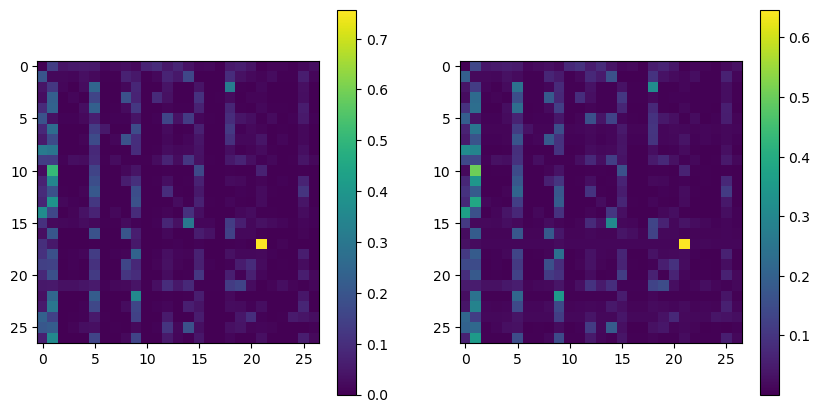

In [26]:
# visualize the learned probabilities
import matplotlib.pyplot as plt
import numpy as np
grad_probs = F.softmax(model.logits.data, dim=-1)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.colorbar(ax[0].imshow(counting_probs.numpy()), ax=ax[0])
plt.colorbar(ax[1].imshow(grad_probs.numpy()), ax=ax[1])
plt.show()

In [39]:
idx0, idx1 = np.where(grad_probs.numpy() > 0.6)
print(f'Greatest conditional probability: {itos[idx1.item()]} | {itos[idx0.item()]}')

Greatest conditional probability: u | q


In [45]:
# sample from the model
num_samples = 10

for s in range(num_samples):
    word, token = '', None
    while token != '.':
        idx = stoi[token] if token is not None else 0
        idx = np.random.choice(len(chars), p=grad_probs[idx].numpy(), size=1).item()
        token = itos[idx]
        word += token if token != '.' else ''
    print(word)

bberian
kovam
zudilishatie
cerikay
zper
jenn
khqjurnamaiy
bah
ril
enncqckmamaniyaruslen
